## Motivation



<!---

What is your dataset?

Why did you choose this/these particular dataset(s)?

What was your goal for the end user's experience?

-->

Our project focuses on studying global life expectancy, with a specific emphasis on Japan. To explore and explain life expectancy from various angles, we have utilized multiple data sources. We chose this topic because it lends itself well to comprehensive analysis and greatly interests many people. Understanding which factors contribute to a longer life is a common curiosity individuals share worldwide. In addition, the topic is broad and offers a temporal element (the development through time) that could be explored and explained through visual representations. Using a statistical approach and examining data across time and space, we could create engaging visualizations that enhance the storytelling aspect of our project.

Our goal was to examine both the economic, social and lifestyle factors that influence life expectancy and also to give the reader an idea of the development of life expectancy globally. To achieve this, we gathered data from sources such as the World Bank, the World Health Organization (WHO), the United Nations, OECD, the human mortality database, and various other independent sources, including Wikipedia. The World Bank provided population data, GDP, and health expenditure information for different countries over the years. WHO data includes life expectancy and cause of death statistics across countries and years. The United Nations was used to find data on countries' diets and meat consumption, while OECD data provided insights into daily activities based on nationality. So we had data both to cover a broad range of factors that influence life expectancy, and also to provide a historical perspective on the development of life expectancy globally.

Our article aimed to create an informative and captivating reading experience. We wanted to combinate much relevant information into one story, such that the reader would be able to both learn something about history and also be able to reflect on their own life and how they can improve their chances of living a long life. Our primary focus was to make the article accessible and understandable to a broad audience, combining readability with engaging visuals to provide an enjoyable reading experience.

### imports

In [10]:
# These are the all the dependencies used in the notebook

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from folium import plugins

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange, Legend, Range1d, Panel, Tabs # (requires bokeh<2.3.3>) (pip install bokeh==2.3.3)
from bokeh.plotting import figure, show, output_file

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import os
import calplot
import json
from urllib.request import urlopen

## Basic stats


<!---

Let's understand the dataset better

Write about your choices in data cleaning and preprocessing

Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

-->

We go through each dataset one by one:

1. [The WHO data on life expectancy for countries over time](https://www.kaggle.com/datasets/ulrikthygepedersen/life-expectancy?fbclid=IwAR0JO7W1_G3prS0O48OITDxvSeQPm64MtaUOIbfNjBCzcHttAUh_tC3xJME)

This dataset is clean from the beginning and consists of 4 columns. The first column is a short-hand code for the country's name; the second column is the country's name, the third column is the year, and the fourth column is the life expectancy.

The data has no missing values and is easy to use. We use this data to plot the development of life expectancy over time for different countries on a global map.

2. [The World Bank data](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?fbclid=IwAR2Jf_Asqt1WWMuQ_S1bobud8Q36WcVEYDx4lF0RrdCprmiESBD0yyNaGDk)

These are the GDP and Health datasets. For both datasets, we did the same preprocessing. The data contains values for years and countries about GDP or health expenditure in dollars per capita.
This data is less clean. There are a lot of NaN values which we have excluded. We preprocess this dataset by combining it with the WHO dataset to get a new dataset with 4 columns, year, country,life expectancy and GDP/Health expenditure.

3. [The UN data](https://www.populationpyramid.net/)

This data is what is used to make the population pyramid plots. Each CSV file we got from here represents one country in one year. The data simply consists of 3 columns, age group, amount males and amount females. The only preprocessing that was necessary here was to combine the number of males and females into 1 column, as we decided not to focus on the difference between male and female in this scope.

4. [the OECD data](https://ourworldindata.org/time-use)

This data is used to plot the time spent on daily activities. The data is clean from the beginning and consists of 3 columns, country, activity, and percentage of people doing the activity.

5. [WHO data on obesity rate, daily caloric intake, prevalence of insufficient physical activity and suicide rate](https://apps.who.int/gho/data/node.main)

For these 4 indicators, we used the most recently available data. For obesity and suicice rates this meant data from year 2016, whereas data from 2019 and 2018 was downloaded for prevalence of insufficient physical activity among adults and daily caloric supply, respectively. These data came clean without NaNs and, thus, did not require further preprocessing. The data files simply include two columns; a country column and the value of the indicator.

6. [Cause-specific mortality rates for Germany, Italy, US and Japan data from WHO](https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates/ghe-leading-causes-of-death)

This data comes clean without NaNs in Excel files for the individual countries. We only kept the 90th percentile of data for each country to visualize that information as the top 10% most common death causes.

7. [Meat consumption data from UN FAO - downloaded from OurWorldinData](https://ourworldindata.org/meat-production)

This data originates from the Food and Agriculture Organization of the United Nations and was obtained via OurWorldinData. The data is clean and did not require further preprocessing before visualization.

8. [The Human Mortality Database](https://www.lifetable.de/)

This website is comprehensive but also by far the messiest to make good use of. Here we obtain the life tabless data tables that can be used to calculate life expectancy and conditioned life expectancy (e.g., given you are this old, how long can you expect to live). This data is used in the "chance of surviving to this age" plot and the plot with the oldest human. For each country, they found sources covering intervals in years that you can check up on. So, for example, some sources may contain data from only every 5 years in some intervals, while other intervals every year, and some years no data at all. In addition, it is very rare for less developed countries to have any sources that go further back in time than the year 2000. The preprocessing consisted of finding a reliable source for each country and year intervals and hopefully finding enough to more or less cover the entire span of 1960 to 2020. (else we simply did linear interpolation between the years we know). The dataset also comes with many other features that had to be sorted out and were separated into male and female, which we simply combined into one category. To give an idea of the chaos of the data, the code for producing the "change of surviving to this age" is listed below. (note we could not just do a general loop for each country and year, as the features vary from dataset to dataset)




#### Early Exploratory Data Analyses

**Life Expectancy by Country over Time (WHO data on life expectancy by country over time)**

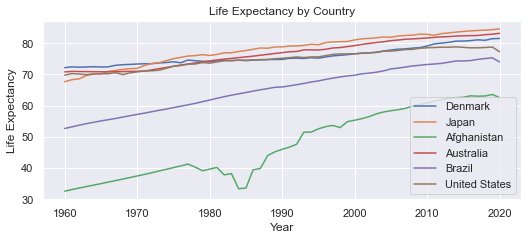

In [40]:
# Load life expectancy data
df_earl = pd.read_csv('life_expectancy_by_country.csv')
i = 0

## Loop over select countries and plot lines ##
countries = ['Denmark', 'Japan', 'Afghanistan', 'Australia', 'Brazil', 'United States']
for country in countries:
    df_country = df_earl[df_earl['country_name'] == country]
    df_country_numpy = df_country['value'].to_numpy()
    plt.plot(np.arange(1960, 2021), df_country_numpy, label=country)
    plt.legend()
plt.ylabel('Life Expectancy')
plt.xlabel('Year')
plt.title('Life Expectancy by Country')
plt.show()

In the plot above, we have visualized the life expectancy over time for select countries. This was part of our very early exploratory data analysis and helped us identify the overall temporal patterns in the data.

**Survival to age x by location in 2019**

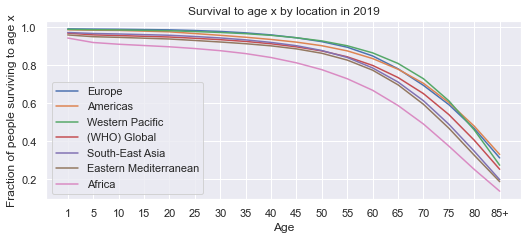

In [41]:
sns.set_theme(style="darkgrid")

# Read in the data
df = pd.read_csv('data_life.csv')
df = df[['Indicator', 'Location', 'Period', 'Value', 'Dim1', 'Dim2']]

# Get only the data for 2019
df_2019 = df[df['Period'] == 2019]
age_groups = ['1-4 years', '5-9 years', '10-14 years', '20-24 years', '25-29 years', '30-34 years', '35-39 years', '40-44 years', '45-49 years', '50-54 years', '55-59 years', '60-64 years', '65-69 years', '70-74 years', '75-79 years', '80-84 years', '85+ years']

# Get the data for all countries
locations = df_2019['Location'].unique()
vals = dict()
for location in locations:
    temp = []
    df_male = df_2019[df_2019['Dim1'] == 'Male']
    df_location = df_male[df_male['Location'] == location]
    df_lx = df_location[df_location['Indicator'] == 'lx - number of people left alive at age x']

    # Get the values for all age groups
    [temp.append(int(df_lx[df_lx['Dim2'] == x]['Value'].to_string().replace(u'\xa0', u'').split()[-1])/100000) for x in age_groups]

    temp.insert(3, (temp[2] + temp[3])/2)
    vals[location] = temp

# Plot the data
ages = ['1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85+']

for key, val in vals.items():
    plt.plot(ages, val, label=key)
    plt.legend()
plt.ylabel('Fraction of people surviving to age x')
plt.xlabel('Age')
plt.title('Survival to age x by location in 2019')
plt.show()

In the preliminary exploratory analysis, we also explored the fraction of people surviving to specific ages apart from the average overall life expectancy at birth for countries.

### Code

In [11]:
# countries: 'Japan', 'Denmark', 'Deutchland', 'Brazil', 'USA', 'Sweden', 'Bolivia', 'South_Africa'

# make dict with countries and years
all_data = dict()

country = "Japan"
# Make plot for Japan 1960
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Japan 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

country = "Denmark"
# Make plot for Denmark 1960
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == 1961]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Denmark 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of Denmark 1901
year = 1901
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df



country = "Deutchland"
# Make plot for Deutchland 1960
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Deutchland 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Brazil 1960
country = "Brazil"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df


# Make plot for Brazil 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for USA 1960
country = "USA"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for USA 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Sweden 1960
country = "Sweden"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for Sweden 2019
year = 2019
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of Sweden 1751
year = 1751
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df
# Make plot for South Africa 1960
country = "South_Africa"
year = 1960
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot for South Africa 2006
year = 2006
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[df['TypeLT'] == 1]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of India 1961
country = "India"
year = 1961
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['TypeLT'] == 1]
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# Make plot of India 2014
year = 2014
df = pd.read_csv('life_tables/' + country + '.csv')
df = df[df['Year1'] == year]
df = df[["Age", "l(x)", "Sex"]]
df = df.groupby(['Age']).sum()
df = df[['l(x)']]
all_data[(country, year)] = df

# For each country, divide by the first value to get a percentage
for key, val in all_data.items():
     divisor = val.head(1).values[0][0]
     for i in range(len(val)):
          val.iloc[i] = val.iloc[i] / divisor * 100
fig = go.Figure()

colors = ['firebrick', 'royalblue', 'green', 'orange', 'purple', 'red', 'black', 'deepskyblue']
styles = ['solid', 'dash', 'dot', 'dashdot']

# For each country, make a plot
for i, country in enumerate(['Japan', 'Denmark', 'Deutchland', 'Brazil', 'USA', 'Sweden', 'South_Africa', 'India']):
     for j, year in enumerate([2019, 2014, 2006, 1961, 1960, 1901, 1751]):
          if year > 2000:
               j = 0
          elif year < 2000 and year > 1950:
               j = 1
          else:
               j = 2

          if (country, year) in all_data:
               vis = 'legendonly'
               if country in ['India', 'Japan']:
                    vis = None
               fig.add_trace(go.Scatter(x=list(all_data[(country, year)].index.values), y=all_data[(country, year)].to_numpy()[:,0].tolist(), name=str(country + ' ' + str(year)).replace('_', ' '),
                                        line=dict(color=colors[i], width=2, dash=styles[j]), opacity=1, mode='lines', visible=vis, showlegend=True))

# Edit the layout
fig.update_layout(title='Chance of surviving till age for various countries and times',
                   xaxis_title='Age (years)',
                   yaxis_title='Chance of surviving to this age (%)',
                   yaxis_range=[0,100],
                   xaxis_range=[0,100])

fig.show()
fig.write_html("Survival_rate.html")

/Users/huayuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/huayuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning:

Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.



## Data Analysis


<!---
Describe your data analysis and explain what you've learned about the dataset.

If relevant, talk about your machine-learning.
-->

From the beginning, we knew we wanted a world map of life-expectancy development for all countries. This would, for the reader, serve as an eye-catcher and an excellent broad way to start the article, while for us, the writers, provide a high-level idea of exciting things to investigate further on. As a matter of fact, we needed to figure out how to focus on Japan before this point even. Then we saw how the life expectancy in Japan actually seemed quite outlying and decided to focus on it. Some interesting observations from this exploratory phase were how life expectancy had improved dramatically in China and, in general, how the world has become more equal in terms of life expectancy, as particularly Africa has a much higher life expectancy now than in 1960.

To make it easier to understand how much these countries have changed, we also made an interactive barplot that compares their life-expectancy from 1960 to 2020. Having a barplot like this makes comparison easier than having to look at the whole world map, which, however, provides for a more holistic and aesthetic experience.

After that, we decided to look more into the distribution of how long people live rather than just having the life expectancy. This gave rise to the "chance of surviving to this age" plot. From this plot, we learned that there are specific characteristics that differentiate the developing countries from the developed countries. Notably, the high mortality rate was apparent from this plot. Moreover, the death rate is closer to linear in developing countries, while in developed countries, it is first flat (almost no one dies before age 50) and then starts to fall.

This discrepancy, we thought, would give rise to different population pyramid structures. So we decided to look into that. Here we also saw a difference, which we made an interactive plot in order for us and the reader to explore.


Furthermore, we wanted to know and show if there is a connection between GDP, Health Expenditure and life expectancy. To do this, we plotted GDP and Health Expenditure against life expectancy for different years. We intuitively understood there was a connection from looking at the scatter plot, but it did not show a linear trend. So we transformed the x-axis into log-space (semi-log plot), and here we saw quite the appropriate fit. So we fitted a linear function in this semilog-space and got a pretty nice fit from eye-balling the plot. 

Ultimately, we decided to transform the data (and regression line) back into a regular (not logarithmic) plot. We thought it looked better and was perhaps easier to grasp for the non-scientific reader. Indeed, we also did this same plot for different years than 2019, but we decided only to include the plot for 2019 on the website, as it alone conveyed the message we were interested in. Including the data from years other than 2019 makes the plot messier and harder to read, and the message is mostly the same. 

One interesting point we saw when looking at the plots from 1960 and 1990 instead of only 2019 is that the logistic regression slope was higher back then. In other words, the GDP and Health Expenditure were predicted to have an even more significant impact on life expectancy back then. This is probably due to the fact that the life expectancy was much lower back then, and the effect of GDP and Health Expenditure is more prominent when the life expectancy is lower. In addition, some countries now have an incredibly high GDP, but it does not represent the actual 'richness' of the country because companies use these countries as tax havens. Furthermore, GDP usually only considers citizens of the country, so countries where many people work in other countries, but send money back to their home country, will have a lower GDP than they should have. Thus whether this observation is meaningful or whether it is just a result of GDP not being a perfect measure of wealth is hard to say. Indeed for Health Expenditure, we saw how the USA spends a lot even with a relatively low life expectancy. This led us to the conclusion that not only do you have to spend many resources, but you also have to spend them in the right way.

 The code for these plots is below.

### Code

**Health expenditure Vs. Life Expectancy**

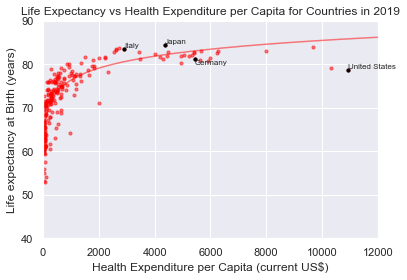

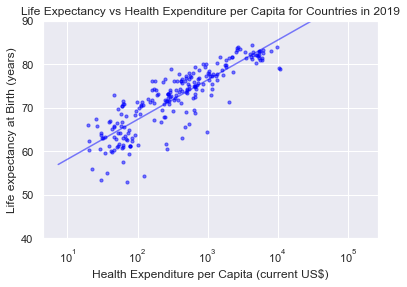

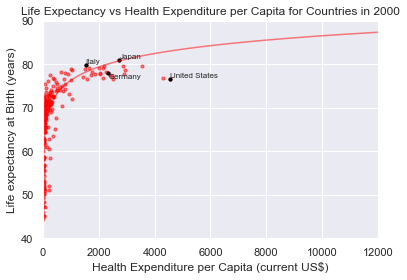

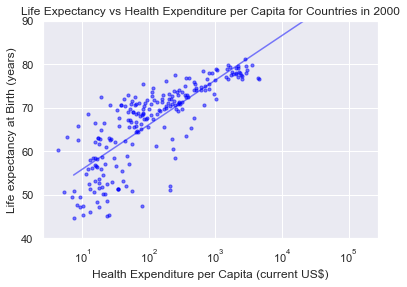

In [12]:
sns.set_theme()

# Life expectancy data
life_expectancy = pd.read_csv('data/API_SP.DYN.LE00.IN_DS2_en_csv_v2_5358385.csv', skiprows=4)

# Health expenditure data
health_expenditure = pd.read_csv('data/API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_5359940.csv', skiprows=4)

years = ['2019', '2000']
for year in years:
    # Only keep columns for life_ex: Country Name, 2019
    # make a copy of life_Expectancy dataframe
    life_ex = life_expectancy.copy()
    life_ex = life_ex[['Country Name', year]].copy()
    # Only keep columns for life_ex: Country Name, 2019
    health_ex = health_expenditure.copy()

    health_ex = health_ex[['Country Name', year]]

    # add new column in health_ex with life expectancy
    health_ex['Life Expectancy at Birth (total years)'] = life_ex[year]

    # rename 2019 column to Health Expenditure per Capita (current US$)
    health_ex.rename(columns={year: 'Health Expenditure per Capita (current US$)'}, inplace=True)

    # Drop nans
    health_ex.dropna(inplace=True)


    # Sort by Health Expenditure per Capita (current US$)
    health_ex.sort_values(by='Health Expenditure per Capita (current US$)', ascending = False, inplace=True)


    # Reset index
    health_ex.reset_index(drop=True, inplace=True)

    # Conditional plot for the year 2020
    df_2020 = health_ex

    # print(df_2020.shape)

    plt.scatter(data=df_2020, x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='red', marker='o', s=10, alpha=0.5, label=year)

    # Fit a linear model between log health expenditure and life expectancy
    reg = LinearRegression().fit(np.log(df_2020['Health Expenditure per Capita (current US$)']).values.reshape(-1, 1), df_2020['Life Expectancy at Birth (total years)'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=2, stop=12, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]

    # Use a red color to symbolize health expenditure
    plt.plot(np.exp(x), y, alpha=0.5, c='red')

    # Annotate Japan with country name, make point bigger
    for row in df_2020.index:
        if df_2020.loc[row, 'Country Name'] in ['Japan', 'Germany', 'Italy', 'United States']:
            plt.scatter(data=df_2020.loc[row, :], x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='black', marker='o', s=10, alpha=1)
            plt.text(x=df_2020.loc[row, 'Health Expenditure per Capita (current US$)'] + 0.2, y=df_2020.loc[row, 'Life Expectancy at Birth (total years)'] + 0.3 - 1.6*(df_2020.loc[row, 'Country Name'] == 'Germany'), s=df_2020.loc[row, 'Country Name'], fontsize=8)

    plt.title('Life Expectancy vs Health Expenditure per Capita for Countries in' + ' ' + year)

    # make y axis go from 0 to 100
    plt.ylim(40, 90)
    plt.xlim(0, 12000)
    plt.xlabel('Health Expenditure per Capita (current US$)')
    plt.ylabel('Life expectancy at Birth (years)')
    plt.show()

    plt.scatter(data=df_2020, x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='blue', marker='o', s=10, alpha=0.5, label=year)
    plt.plot(np.exp(x), y, alpha=0.5, c='blue')
    plt.title('Life Expectancy vs Health Expenditure per Capita for Countries in' + ' ' + year)
    # make xaxis log scale
    plt.xscale('log')
    # make y axis go from 0 to 100
    plt.ylim(40, 90)
    plt.xlabel('Health Expenditure per Capita (current US$)')
    plt.ylabel('Life expectancy at Birth (years)')
    plt.show()




**GDP Vs. Life Expectancy**

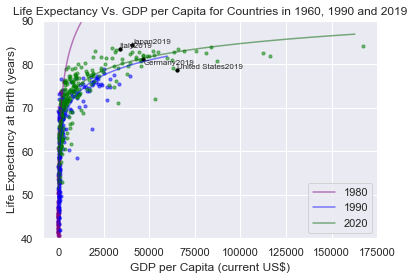

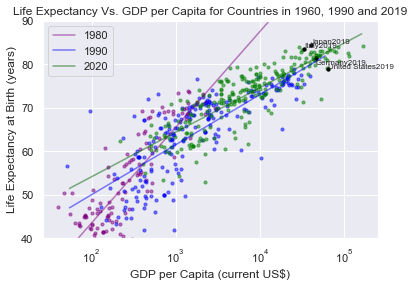

In [13]:
sns.set_theme()

for semilog in [False, True]:
    # Read in the data for GDP
    df_GDP = pd.read_csv('GDP_data/data.csv')

    # Read in the data for life expectancy
    df = pd.read_csv('life_expectancy_by_country.csv')
    df['GDP'] = np.nan

    # Loop over rows in df
    for row in df.index:
        # Get the country name
        country = df.loc[row, 'country_name']
        # Get the year of the row
        year = df.loc[row, 'year']
        # Get the GDP value for the country
        GDP = df_GDP.loc[df_GDP['Country Name'] == country, str(year)].values[0]
        # Set the GDP value in df
        df.loc[row, 'GDP'] = GDP

    # Only keep data from 1980, 1990 and 2020
    df = df.loc[df['year'].isin([1960, 1990, 2019]), :]

    # Remove Hong Kong and Macao from data
    df = df.loc[~df['country_name'].isin(['Hong Kong SAR, China', 'Macao SAR, China']), :]

    # Remove rows with any nan values from data
    df = df.loc[~df.isna().any(axis=1), :]

    # Conditional plot for the year 1980
    df_1980 = df.loc[df['year'] == 1960, :]
    plt.scatter(data=df_1980, x='GDP', y='value', c='purple', marker='o', s=10, alpha=0.5, label='_nolegend_')

    # Fit a linear model between log GDP and life expectancy
    reg = LinearRegression().fit(np.log(df_1980['GDP']).values.reshape(-1, 1), df_1980['value'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=4, stop=11, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]
    plt.plot(np.exp(x), y, alpha=0.5, c='purple', label='1980')

    # Conditional plot for the year 1990
    df_1990 = df.loc[df['year'] == 1990, :]
    plt.scatter(data=df_1990, x='GDP', y='value', c='blue', marker='o', s=10, alpha=0.5, label='_nolegend_')

    # Fit a linear model between log GDP and life expectancy
    reg = LinearRegression().fit(np.log(df_1990['GDP']).values.reshape(-1, 1), df_1990['value'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=4, stop=11, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]
    plt.plot(np.exp(x), y, alpha=0.5, c='blue', label='1990')


    # Conditional plot for the year 2020
    df_2020 = df.loc[df['year'] == 2019, :]
    plt.scatter(data=df_2020, x='GDP', y='value', c='green', marker='o', s=10, alpha=0.5, label='_nolegend_')

    # Fit a linear model between log GDP and life expectancy
    reg = LinearRegression().fit(np.log(df_2020['GDP']).values.reshape(-1, 1), df_2020['value'].values.reshape(-1, 1))

    # Plot the linear model
    x = np.linspace(start=4, stop=12, num=100)
    y = reg.coef_[0][0] * x + reg.intercept_[0]
    plt.plot(np.exp(x), y, alpha=0.5, c='darkgreen', label='2020')
    plt.legend()

    # Annotate Japan with country name, make point bigger
    df = df.loc[df['year'].isin([2019]), :]
    for row in df.index:
        if df.loc[row, 'country_name'] in ['Japan', 'Germany', 'Italy', 'United States']:
            plt.scatter(data=df.loc[row, :], x='GDP', y='value', c='black', marker='o', s=10, alpha=1)
            plt.text(x=df.loc[row, 'GDP'] + 0.2, y=df.loc[row, 'value'] + 0.3 - 1.6*(df.loc[row, 'country_name'] == 'Germany'), s=df.loc[row, 'country_name'] + str(2019), fontsize=8)

    plt.title('Life Expectancy Vs. GDP per Capita for Countries in 1960, 1990 and 2019')

    # Make y axis go from 0 to 100
    plt.ylim(40, 90)
    plt.xlabel('GDP per Capita (current US$)')
    plt.ylabel('Life Expectancy at Birth (years)')
    # make xaxis log scale
    if semilog:
        plt.xscale('log')
    plt.show()


## Genre

<!---
Which genre of data story did you use?

Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
-->

**Genre** <br>
To tell the data story of global life expectancy, we chose to follow a **magazine style** narrative genre. The reasoning behind this choice is to provide broad appeal, both visually and content-wise while delivering an informative reading experience. The reader is presented with an article that flows naturally with easily understandable language but also includes rich data visualizations that support the narrative.

**Visual Narrative Tools from Segal and Heer** <br>
For visual structuring, we aim to provide our readers a **Consistent Visual Platform**. This is seen in the visualizations where we use similar color themes for plots that are within the same category in terms of content and interactivity. Moreover, all the content is on a single page. All that the user needs to do is to scroll down, a gesture that is familiar to most readers and is, thus, in line with our goal of having a broad appeal while providing narrative continuity. There is no need to switch pages. All you do is simply scroll. For the interactive visualizations, readers can get **close-ups** of the data, navigate the **distinctive features**, and **zooming** in on the ones that they find most interesting. In the very beginning, we have chosen to include a large map of life expectancy over time across the world. The idea was to provide a visually catchy introduction to capture and retain the reader's attention from the very beginning of the narrative. This map provides **animated transitions** through time in **motion** for life expectancy, over time, for the entire world and provides an excellent overview of the temporal aspect in an aesthetically pleasing and informative manner.

**Narrative Structure Tools from Segal and Heer** <br>
While the ordering of our article is thought to be **linear**, certain sections are still readable independently from each other. This is due to certain choices we have made with narrative structuring. Generally, the article can be divided into 4 main parts with the appropriate **Captions / Headlines**. First, it begins with an **Introductory Text** that introduces the main topics and questions that the article will explore. Second, we cover global life expectancy. Third, we zoom in on Japan for the narrative focus. And finally, we provide a **Summary** of the answers that were found. The aforementioned sections can be read independently from each other in terms of ordering, despite the intention being from top to bottom in a linear way. Throughout the article, we include sources along with the **Accompanying Articles** for everything that is written and annotations on plots so they are made even more intuitive. The interactive plots all have **Stimulating Default Views**, where the reader can **Hover** over the data and get an extra layer of information while also being able to **Highlight/filter** the shown data for the bar charts, specifically. We also include visualizations with **Very Limited Interactivity**.


**Narrative Reflections**
While the narrative mainly remains author-driven, we introduce reader-driven elements through interactive visualizations. Consequently, our data story does have elements from the **Interactive Slideshow structure** since free interactivity is incorporated mid-narrative within the confines of the respective sections. Hence, readers can explore specific aspects of the content/data before moving on to the next part of the story when they are ready to do so. The individual slides would, in our case, be the sections that follow the **Martini Glass structure**, where the author-intended messaging is communicated before the user is presented with the option to explore interactively.

## Visualizations

<!---

Explain the visualizations you've chosen.

Why are they right for the story you want to tell?
-->


In this section, we will provide a thorough walkthrough of all the visualizations included in the final data story and why we chose them. The interactive plots might not be visible before running the code; all plots can also be seen on the website.

### World Map of Life Expectancy data from Kaggle (WHO)

In [42]:
# Load life expectancy data
df = pd.read_csv("life_expectancy_by_country.csv")

# Define color palette
colors = px.colors.sequential.YlGnBu

# Define Choropleth map with Plotly
fig = px.choropleth(df, locations="country_name", 
                    locationmode='country names', color="value", 
                    hover_name="country_name", 
                    animation_frame="year",
                    projection="natural earth",
                    range_color=[30, 90],
                    labels={'value':'Years'},
                    color_continuous_scale=['rgb(255, 255, 255)'] + px.colors.sequential.YlGnBu + ['rgb(0, 0, 0)'])
# Updated Layout
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.update_layout(title_text='Life Expectancy at Birth World Map ',title_x=0.5,titlefont_size=20,),
fig.update_layout(height=600, margin=dict(l=80, r=80, t=40, b=50))

# Set playback settings
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5

# Show Plotted Figure
fig.show()

## Store Image of Generated PLot in HTML
fig.write_html("world.html")

We chose above world map as the first visualization with the idea of starting out with a broad visually appealing overview of not only the geographical, but also the temporal distribution of life expectancy. We made it interactive so that the reader has plenty of options to explore and play with it and reveal extra information by hovering, zooming and dragging.

### Life Expectancy Bokeh Interactive Bar charts

In [43]:
country_data = df

## REGIONS ##

# Create a list of regions in the data
region_list = ['Africa Eastern and Southern', 'Africa Western and Central', 'Central Europe and the Baltics', 'Caribbean small states', 'East Asia & Pacific', 'Europe & Central Asia', 'Euro area', 'European Union', 'Latin America & Caribbean', 'Middle East & North Africa', 'North America', 'Pacific island small states', 'South Asia', 'Sub-Saharan Africa'] 

# Remove rows that are not in the region list
country_data = country_data[country_data['country_name'].isin(region_list)]

# Remove rows that are not years 1960, 1980, 2000, 2020
country_data = country_data[country_data['year'].isin([1960, 1980, 2000, 2020])]

# Reset index
country_data = country_data.reset_index(drop=True)

# Add columns 1960, 1980, 2000, 2020 with values from value column corresponding to year
country_data['1960'] = country_data['value'][country_data['year'] == 1960]
country_data['1980'] = country_data['value'][country_data['year'] == 1980]
country_data['2000'] = country_data['value'][country_data['year'] == 2000]
country_data['2020'] = country_data['value'][country_data['year'] == 2020]

# make a new data frame with country_name and 1960, 1980, 2000, 2020 columns
country_data_new = country_data[['country_name', '1960', '1980', '2000', '2020']]

# remove columns 1980, 2000, 2020
country_data_1960_ = country_data_new.drop(columns=['1980', '2000', '2020'])
country_data_1980_ = country_data_new.drop(columns=['1960', '2000', '2020'])
country_data_2000_ = country_data_new.drop(columns=['1960', '1980', '2020'])
country_data_2020_ = country_data_new.drop(columns=['1960', '1980', '2000'])

# remove nan rows in country_data_1960_
country_data_1960_ = country_data_1960_.dropna()
# reset index
country_data_1960_ = country_data_1960_.reset_index(drop=True)

# remove nan rows in country_data_1980_
country_data_1980_ = country_data_1980_.dropna()
# reset index
country_data_1980_ = country_data_1980_.reset_index(drop=True)

# remove nan rows in country_data_2000_
country_data_2000_ = country_data_2000_.dropna()
# reset index
country_data_2000_ = country_data_2000_.reset_index(drop=True)

# remove nan rows in country_data_2020_
country_data_2020_ = country_data_2020_.dropna()
# reset index
country_data_2020_ = country_data_2020_.reset_index(drop=True)

# add 1960, 1980, 2000 columns to country_data_2020_
country_data_2020_['2000'] = country_data_2000_['2000']
country_data_2020_['1980'] = country_data_1980_['1980']
country_data_2020_['1960'] = country_data_1960_['1960']

# Sort by 2020 column
country_data_2020_ = country_data_2020_.sort_values(by=['2020'], ascending=False)

# reset index
country_data_2020_ = country_data_2020_.reset_index(drop=True)

# Output in notebook
output_notebook()

# Choose table columns to plot
table = country_data_2020_.set_index('country_name')
source = ColumnDataSource(table)

# Create figure
p = figure(x_range=FactorRange(factors=table.index),
           plot_width=600,
           plot_height=450,
           title='Life expectancy by region in select years', 
           x_axis_label='Region', 
           y_axis_label='Years')

# Set color palette
cmap = sns.color_palette('pastel', len(table.columns)).as_hex()

# Create dictionary of bars
bar = {}

# Create list of items to add to legend
items = []

# Plot each column
for i, crime in enumerate(list(table.columns)):
    bar[crime] = p.vbar(x='country_name', 
                    top=crime, 
                    source=source, 
                    width=0.7,
                    color=cmap[i],
                    fill_alpha=0.6,
                    muted=True, 
                    muted_alpha=0.005) 
    items.append((crime, [bar[crime]]))
bar['2020'].muted = False
bar['1960'].muted = False
p.xaxis.major_label_orientation = 1

# Set y range
p.y_range = Range1d(0, 100)

# Add legend
legend = Legend(items=items)
p.add_layout(legend, 'left')    
p.legend.click_policy = 'mute'

## COUNTRIES ##

countries_ja = pd.read_csv('life_expectancy_by_countries_select.csv')

# add columns 1960, 1980, 2000, 2020 with values from value column corresponding to year
countries_ja['1960'] = countries_ja['value'][countries_ja['year'] == 1960]
countries_ja['1980'] = countries_ja['value'][countries_ja['year'] == 1980]
countries_ja['2000'] = countries_ja['value'][countries_ja['year'] == 2000]
countries_ja['2020'] = countries_ja['value'][countries_ja['year'] == 2020]

# make a new data frame with country_name and 1960, 1980, 2000, 2020 columns
country_data_new_ja = countries_ja[['country_name', '1960', '1980', '2000', '2020']]

# remove columns 1980, 2000, 2020
country_data_1960_ja = country_data_new_ja.drop(columns=['1980', '2000', '2020'])
country_data_1980_ja = country_data_new_ja.drop(columns=['1960', '2000', '2020'])
country_data_2000_ja = country_data_new_ja.drop(columns=['1960', '1980', '2020'])
country_data_2020_ja = country_data_new_ja.drop(columns=['1960', '1980', '2000'])

# remove nan rows in country_data_1960_
country_data_1960_ja = country_data_1960_ja.dropna()
# reset index
country_data_1960_ja = country_data_1960_ja.reset_index(drop=True)

# remove nan rows in country_data_1980_
country_data_1980_ja = country_data_1980_ja.dropna()
# reset index
country_data_1980_ja = country_data_1980_ja.reset_index(drop=True)

# remove nan rows in country_data_2000_
country_data_2000_ja = country_data_2000_ja.dropna()
# reset index
country_data_2000_ja = country_data_2000_ja.reset_index(drop=True)

# remove nan rows in country_data_2020_
country_data_2020_ja = country_data_2020_ja.dropna()
# reset index
country_data_2020_ja = country_data_2020_ja.reset_index(drop=True)

# add 1960, 1980, 2000 columns to country_data_2020_
country_data_2020_ja['2000'] = country_data_2000_ja['2000']
country_data_2020_ja['1980'] = country_data_1980_ja['1980']
country_data_2020_ja['1960'] = country_data_1960_ja['1960']

# Sort by 2020 column
country_data_2020_ja = country_data_2020_ja.sort_values(by=['2020'], ascending=False)
country_data_2020_ja = country_data_2020_ja.reset_index(drop=True)

table = country_data_2020_ja.set_index('country_name')

# Choose table columns to plot
source = ColumnDataSource(table)

# Create figure
p_c = figure(x_range=FactorRange(factors=table.index),
           plot_width=600,
           plot_height=390,
           title='Life expectancy by country in select years', 
           x_axis_label='Country', 
           y_axis_label='Years')

# Set color palette
cmap = sns.color_palette('pastel', len(table.columns)).as_hex()

# Create dictionary of bars
bar = {}

# Create list of items to add to legend
items = []

# Plot each column
for i, crime in enumerate(list(table.columns)):
    bar[crime] = p_c.vbar(x='country_name', 
                    top=crime, 
                    source=source, 
                    width=0.7,
                    color=cmap[i],
                    fill_alpha=0.6,
                    muted=True, 
                    muted_alpha=0.005) 
    items.append((crime, [bar[crime]]))
bar['2020'].muted = False
bar['1960'].muted = False
p_c.xaxis.major_label_orientation = 1

# Set y range
p_c.y_range = Range1d(0, 100)

# Add legend
legend = Legend(items=items)

# Add legend
p_c.add_layout(legend, 'left')  

# Set legend click policy
p_c.legend.click_policy = 'mute'

# Combine the two plots into one
tab1 = Panel(child=p, title="Regions")
tab2 = Panel(child=p_c, title="Countries")
output_file('bokeh.html')
show(Tabs(tabs=[tab1, tab2]))


Loading BokehJS ...

The main advantage of the interactive bar chart above is that it provides the reader with information about how much life expectancy has changed for specific regions/countries. By displaying overlaying bars for the four different years, it is easily visible which regions/countries specifically have developed a lot in that time span. This information is more easily conveyed in the bar chart format than on a map since we focus on select countries/regions here. The reader can click on the years he/she desires and filter the data accordingly. For the 'Countries' pane, we can see how a country such as China has significantly increased its life expectancy from 1960 to 2020. We deliberately chose to display the years 1960 and 2020 since we believe these years and the difference between them show the most considerable change and are the most stimulating default view for the reading.

### Population Distribution Bokeh plots

In [44]:
## Load the data files for the countries - 2020 ##

afghanistan = pd.read_csv('data/Afghanistan-2023.csv')
afghanistan['Afghanistan'] = afghanistan['M'] + afghanistan['F']

australia = pd.read_csv('data/Australia-2023.csv')
australia['Australia'] = australia['M'] + australia['F']

canada = pd.read_csv('data/Canada-2023.csv')
canada['Canada'] = canada['M'] + canada['F']

china = pd.read_csv('data/China-2023.csv')
china['China'] = china['M'] + china['F']

denmark = pd.read_csv('data/Denmark-2023.csv')
denmark['Denmark'] = denmark['M'] + denmark['F']

germany = pd.read_csv('data/Germany-2023.csv')
germany['Germany'] = germany['M'] + germany['F']

india = pd.read_csv('data/India-2023.csv')
india['India'] = india['M'] + india['F']

italy = pd.read_csv('data/Italy-2023.csv')
italy['Italy'] = italy['M'] + italy['F']

japan = pd.read_csv('data/Japan-2023.csv')
japan['Japan'] = japan['M'] + japan['F']

korea = pd.read_csv('data/Republic of Korea-2023.csv')
korea['South Korea'] = korea['M'] + korea['F']

sweden = pd.read_csv('data/Sweden-2023.csv')
sweden['Sweden'] = sweden['M'] + sweden['F']

uk = pd.read_csv('data/United Kingdom-2023.csv')
uk['United Kingdom'] = uk['M'] + uk['F']

us = pd.read_csv('data/United States of America-2023.csv')
us['United States'] = us['M'] + us['F']

venezuela = pd.read_csv('data/Venezuela-2023.csv')
venezuela['Venezuela'] = venezuela['M'] + venezuela['F']

world = pd.read_csv('data/WORLD-2023.csv')
world['World'] = world['M'] + world['F']

# create new dataframe with columns: Age, Afghanistan, Australia, Canada, China, Denmark, Germany, India, Italy, Japan, Korea, Sweden, UK, US, Venezuela, World
df = pd.DataFrame(columns=['Age', 'Afghanistan', 'Australia', 'Canada', 'China', 'Denmark', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Sweden', 'United Kingdom', 'United States', 'Venezuela', 'World'])

# add age column
df['Age'] = afghanistan['Age']

# add country columns
df['Afghanistan'] = afghanistan['Afghanistan']
df['Australia'] = australia['Australia']
df['Canada'] = canada['Canada']
df['China'] = china['China']
df['Denmark'] = denmark['Denmark']
df['Germany'] = germany['Germany']
df['India'] = india['India']
df['Italy'] = italy['Italy']
df['Japan'] = japan['Japan']
df['South Korea'] = korea['South Korea']
df['Sweden'] = sweden['Sweden']
df['United Kingdom'] = uk['United Kingdom']
df['United States'] = us['United States']
df['Venezuela'] = venezuela['Venezuela']
df['World'] = world['World']

# replace each value in country name columns with percent of sum of column
df['Afghanistan'] = (df['Afghanistan'] / df['Afghanistan'].sum()) * 100
df['Australia'] = (df['Australia'] / df['Australia'].sum()) * 100
df['Canada'] = (df['Canada'] / df['Canada'].sum()) * 100
df['China'] = (df['China'] / df['China'].sum()) * 100
df['Denmark'] = (df['Denmark'] / df['Denmark'].sum()) * 100
df['Germany'] = (df['Germany'] / df['Germany'].sum()) * 100
df['India'] = (df['India'] / df['India'].sum()) * 100
df['Italy'] = (df['Italy'] / df['Italy'].sum()) * 100
df['Japan'] = (df['Japan'] / df['Japan'].sum()) * 100
df['South Korea'] = (df['South Korea'] / df['South Korea'].sum()) * 100
df['Sweden'] = (df['Sweden'] / df['Sweden'].sum()) * 100
df['United Kingdom'] = (df['United Kingdom'] / df['United Kingdom'].sum()) * 100
df['United States'] = (df['United States'] / df['United States'].sum()) * 100
df['Venezuela'] = (df['Venezuela'] / df['Venezuela'].sum()) * 100
df['World'] = (df['World'] / df['World'].sum()) * 100

output_notebook()

table = df.set_index('Age')
source = ColumnDataSource(table)

p = figure(x_range=FactorRange(factors=table.index),
           width=800,
           height=450,
           title='Population Distribution by Age in 2022', 
           x_axis_label='Age', 
           y_axis_label='%')

cmap = sns.color_palette('pastel', len(table.columns)).as_hex()

bar = {}
items = []

for i, crime in enumerate(list(table.columns)):
    bar[crime] = p.vbar(x='Age', 
                    top=crime, 
                    source=source, 
                    width=0.7,
                    color=cmap[i],
                    fill_alpha=0.6,
                    muted=True, 
                    muted_alpha=0.005) 
    items.append((crime, [bar[crime]]))
bar['Germany'].muted = False
bar['Japan'].muted = False
bar['Afghanistan'].muted = False
p.xaxis.major_label_orientation = 1
p.y_range = Range1d(0, 20)

legend = Legend(items=items)
p.add_layout(legend, 'left')    
p.legend.click_policy = 'mute'

## Load country data again, this time for 1960 ##

afghanistan_1960 = pd.read_csv('data/Afghanistan-1960.csv')
afghanistan_1960['Afghanistan'] = afghanistan_1960['M'] + afghanistan_1960['F']

australia_1960 = pd.read_csv('data/Australia-1960.csv')
australia_1960['Australia'] = australia_1960['M'] + australia_1960['F']

canada_1960 = pd.read_csv('data/Canada-1960.csv')
canada_1960['Canada'] = canada_1960['M'] + canada_1960['F']

china_1960 = pd.read_csv('data/China-1960.csv')
china_1960['China'] = china_1960['M'] + china_1960['F']

denmark_1960 = pd.read_csv('data/Denmark-1960.csv')
denmark_1960['Denmark'] = denmark_1960['M'] + denmark_1960['F']

germany_1960 = pd.read_csv('data/Germany-1960.csv')
germany_1960['Germany'] = germany_1960['M'] + germany_1960['F']

india_1960 = pd.read_csv('data/India-1960.csv')
india_1960['India'] = india_1960['M'] + india_1960['F']

italy_1960 = pd.read_csv('data/Italy-1960.csv')
italy_1960['Italy'] = italy_1960['M'] + italy_1960['F']

japan_1960 = pd.read_csv('data/Japan-1960.csv')
japan_1960['Japan'] = japan_1960['M'] + japan_1960['F']

korea_1960 = pd.read_csv('data/Republic of Korea-1960.csv')
korea_1960['South Korea'] = korea_1960['M'] + korea_1960['F']

sweden_1960 = pd.read_csv('data/Sweden-1960.csv')
sweden_1960['Sweden'] = sweden_1960['M'] + sweden_1960['F']

uk_1960 = pd.read_csv('data/United Kingdom-1960.csv')
uk_1960['United Kingdom'] = uk_1960['M'] + uk_1960['F']

us_1960= pd.read_csv('data/United States of America-1960.csv')
us_1960['United States'] = us_1960['M'] + us_1960['F']

venezuela_1960 = pd.read_csv('data/Venezuela-1960.csv')
venezuela_1960['Venezuela'] = venezuela_1960['M'] + venezuela_1960['F']

world_1960 = pd.read_csv('data/WORLD-1960.csv')
world_1960['World'] = world_1960['M'] + world_1960['F']

# create new dataframe with columns: Age, Afghanistan, Australia, Canada, China, Denmark, Germany, India, Italy, Japan, Korea, Sweden, UK, US, Venezuela, World
df_1960 = pd.DataFrame(columns=['Age', 'Afghanistan', 'Australia', 'Canada', 'China', 'Denmark', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Sweden', 'United Kingdom', 'United States', 'Venezuela', 'World'])

# add age column
df_1960['Age'] = afghanistan_1960['Age']

# add country columns
df_1960['Afghanistan'] = afghanistan_1960['Afghanistan']
df_1960['Australia'] = australia_1960['Australia']
df_1960['Canada'] = canada_1960['Canada']
df_1960['China'] = china_1960['China']
df_1960['Denmark'] = denmark_1960['Denmark']
df_1960['Germany'] = germany_1960['Germany']
df_1960['India'] = india_1960['India']
df_1960['Italy'] = italy_1960['Italy']
df_1960['Japan'] = japan_1960['Japan']
df_1960['South Korea'] = korea_1960['South Korea']
df_1960['Sweden'] = sweden_1960['Sweden']
df_1960['United Kingdom'] = uk_1960['United Kingdom']
df_1960['United States'] = us_1960['United States']
df_1960['Venezuela'] = venezuela_1960['Venezuela']
df_1960['World'] = world_1960['World']

# replace each value in country name columns with percent of sum of column
df_1960['Afghanistan'] = (df_1960['Afghanistan'] / df_1960['Afghanistan'].sum()) * 100
df_1960['Australia'] = (df_1960['Australia'] / df_1960['Australia'].sum()) * 100
df_1960['Canada'] = (df_1960['Canada'] / df_1960['Canada'].sum()) * 100
df_1960['China'] = (df_1960['China'] / df_1960['China'].sum()) * 100
df_1960['Denmark'] = (df_1960['Denmark'] / df_1960['Denmark'].sum()) * 100
df_1960['Germany'] = (df_1960['Germany'] / df_1960['Germany'].sum()) * 100
df_1960['India'] = (df_1960['India'] / df_1960['India'].sum()) * 100
df_1960['Italy'] = (df_1960['Italy'] / df_1960['Italy'].sum()) * 100
df_1960['Japan'] = (df_1960['Japan'] / df_1960['Japan'].sum()) * 100
df_1960['South Korea'] = (df_1960['South Korea'] / df_1960['South Korea'].sum()) * 100
df_1960['Sweden'] = (df_1960['Sweden'] / df_1960['Sweden'].sum()) * 100
df_1960['United Kingdom'] = (df_1960['United Kingdom'] / df_1960['United Kingdom'].sum()) * 100
df_1960['United States'] = (df_1960['United States'] / df_1960['United States'].sum()) * 100
df_1960['Venezuela'] = (df_1960['Venezuela'] / df_1960['Venezuela'].sum()) * 100
df_1960['World'] = (df_1960['World'] / df_1960['World'].sum()) * 100

output_notebook()

table = df_1960.set_index('Age')
source = ColumnDataSource(table)

p_1960 = figure(x_range=FactorRange(factors=table.index),
           width=800,
           height=450,
           title='Population Distribution by Age in 1960', 
           x_axis_label='Age', 
           y_axis_label='%')

cmap = sns.color_palette('pastel', len(table.columns)).as_hex()

bar = {}
items = []

for i, crime in enumerate(list(table.columns)):
    bar[crime] = p_1960.vbar(x='Age', 
                    top=crime, 
                    source=source, 
                    width=0.7,
                    color=cmap[i],
                    fill_alpha=0.6,
                    muted=True, 
                    muted_alpha=0.005) 
    items.append((crime, [bar[crime]]))
bar['Germany'].muted = False
bar['Japan'].muted = False
bar['Afghanistan'].muted = False
p_1960.xaxis.major_label_orientation = 1
p_1960.y_range = Range1d(0, 20)

legend = Legend(items=items)
p_1960.add_layout(legend, 'left')    
p_1960.legend.click_policy = 'mute'

## Combine into single plot ##

tab1 = Panel(child=p, title="2022")
tab2 = Panel(child=p_1960, title="1960")
output_file('age.html')
show(Tabs(tabs=[tab2, tab1]))

Loading BokehJS ...

Loading BokehJS ...

Going beyond life expectancy, we also wish to examine the population structure of countries in terms of age. Typically, these distributions are displayed as 'population pyramids'. However, we also wanted to compare different countries to each other, and we thought It would be confusing to have entire pyramids overlayed upon each other. That is why we decided to sum the females and males, resulting in the plot above. As with the interactive bar chart for life expectancy, the reader is again able to toggle data for the respective countries where we have chosen what we think is a stimulating default view -having two wealthy countries, a western and an eastern; Germany and Japan, but also including the crisis struck nation, Afghanistan. We opted to include a second pane of data for 1960 to show that the distribution changes as the population ages.

### Survival Rate Plot

In the preliminary exploratory data analysis, we made the static plot; "Survival to age x by location in 2019" (see **Basic Stats**). To provide the reader with even more insights we decided to make that plot interactive using Plotly. Thus, it is possible to include data for more countries and the reader can now click on the countries to compare. Moreover, to distinguish between the different years of data, we differentiate between dashed lines and normal lines. The interactive survival rate plot can be seen in the final part of the **Basic Stats** section.

### Health Expenditure and Life Expectancy

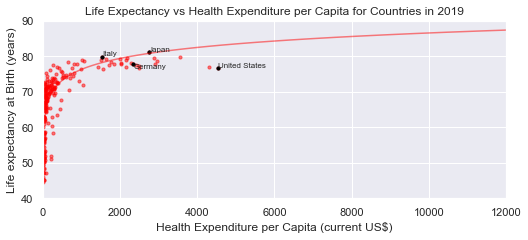

In [45]:
sns.set_theme()

# Conditional plot for the year 2020
df_2020 = health_ex

plt.scatter(data=df_2020, x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='red', marker='o', s=10, alpha=0.5, label='2019')

# Fit a linear model between log health expenditure and life expectancy
reg = LinearRegression().fit(np.log(df_2020['Health Expenditure per Capita (current US$)']).values.reshape(-1, 1), df_2020['Life Expectancy at Birth (total years)'].values.reshape(-1, 1))

# Plot the linear model
x = np.linspace(start=4, stop=12, num=100)
y = reg.coef_[0][0] * x + reg.intercept_[0]

# Use a red color to symbolize health expenditure
plt.plot(np.exp(x), y, alpha=0.5, c='red')

# Annotate Japan with country name, make point bigger
for row in df_2020.index:
    if df_2020.loc[row, 'Country Name'] in ['Japan', 'Germany', 'Italy', 'United States']:
        plt.scatter(data=df_2020.loc[row, :], x='Health Expenditure per Capita (current US$)', y='Life Expectancy at Birth (total years)', c='black', marker='o', s=10, alpha=1)
        plt.text(x=df_2020.loc[row, 'Health Expenditure per Capita (current US$)'] + 0.2, y=df_2020.loc[row, 'Life Expectancy at Birth (total years)'] + 0.3 - 1.6*(df_2020.loc[row, 'Country Name'] == 'Germany'), s=df_2020.loc[row, 'Country Name'], fontsize=8)

plt.title('Life Expectancy vs Health Expenditure per Capita for Countries in 2019')

# make y axis go from 0 to 100
plt.ylim(40, 90)
plt.xlim(0, 12000)
plt.xlabel('Health Expenditure per Capita (current US$)')
plt.ylabel('Life expectancy at Birth (years)')
plt.show()

In the **Data Analysis** section we made different versions for the above plot containing life expectancy vs health expenditure per capita data where we did regression for multiple years and experimented with and without log-axes. In the end, we decided on the above plot, since we thought it would be the most intuitive for the reader to understand. The point of this plot is to show that health expenditure only matters until a certain point for life expectancy. It also matters how the money is spent.

### GDP Vs. Life Expectancy

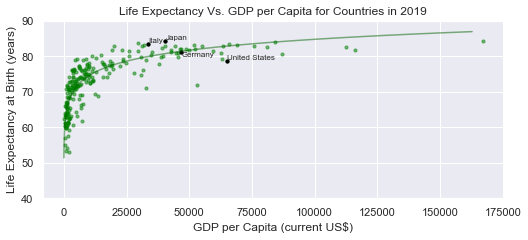

In [46]:
# Read in the data for GDP
df_GDP = pd.read_csv('GDP_data/data.csv')

# Read in the data for life expectancy
df = pd.read_csv('life_expectancy_by_country.csv')
df['GDP'] = np.nan

# Loop over rows in df
for row in df.index:
    # Get the country name
    country = df.loc[row, 'country_name']
    # Get the year of the row
    year = df.loc[row, 'year']
    # Get the GDP value for the country
    GDP = df_GDP.loc[df_GDP['Country Name'] == country, str(year)].values[0]
    # Set the GDP value in df
    df.loc[row, 'GDP'] = GDP

# Save new data frame
df.to_csv('life_expectancy_by_country_with_GDP.csv')

sns.set_theme()

# Load data
df = pd.read_csv('life_expectancy_by_country_with_GDP.csv')

# Only keep data from 1980, 1990 and 2020
df = df.loc[df['year'].isin([1980, 1990, 2019]), :]

# Remove Hong Kong and Macao from data
df = df.loc[~df['country_name'].isin(['Hong Kong SAR, China', 'Macao SAR, China']), :]

# Remove rows with any nan values from data
df = df.loc[~df.isna().any(axis=1), :]

# Conditional plot for the year 1980
df_1980 = df.loc[df['year'] == 1980, :]

# Fit a linear model between log GDP and life expectancy
reg = LinearRegression().fit(np.log(df_1980['GDP']).values.reshape(-1, 1), df_1980['value'].values.reshape(-1, 1))

# Plot the linear model
x = np.linspace(start=4, stop=11, num=100)
y = reg.coef_[0][0] * x + reg.intercept_[0]

# Conditional plot for the year 1990
df_1990 = df.loc[df['year'] == 1990, :]

# Fit a linear model between log GDP and life expectancy
reg = LinearRegression().fit(np.log(df_1990['GDP']).values.reshape(-1, 1), df_1990['value'].values.reshape(-1, 1))

# Plot the linear model
x = np.linspace(start=4, stop=11, num=100)
y = reg.coef_[0][0] * x + reg.intercept_[0]

# Conditional plot for the year 2020
df_2020 = df.loc[df['year'] == 2019, :]
plt.scatter(data=df_2020, x='GDP', y='value', c='green', marker='o', s=10, alpha=0.5, label='2020')

# Fit a linear model between log GDP and life expectancy
reg = LinearRegression().fit(np.log(df_2020['GDP']).values.reshape(-1, 1), df_2020['value'].values.reshape(-1, 1))

# Plot the linear model
x = np.linspace(start=4, stop=12, num=100)
y = reg.coef_[0][0] * x + reg.intercept_[0]
plt.plot(np.exp(x), y, alpha=0.5, c='darkgreen')

# Annotate Japan with country name, make point bigger
df = df.loc[df['year'].isin([2019]), :]
for row in df.index:
    if df.loc[row, 'country_name'] in ['Japan', 'Germany', 'Italy', 'United States']:
        plt.scatter(data=df.loc[row, :], x='GDP', y='value', c='black', marker='o', s=10, alpha=1)
        plt.text(x=df.loc[row, 'GDP'] + 0.2, y=df.loc[row, 'value'] + 0.3 - 1.6*(df.loc[row, 'country_name'] == 'Germany'), s=df.loc[row, 'country_name'], fontsize=8)

plt.title('Life Expectancy Vs. GDP per Capita for Countries in 2019')

# Make y axis go from 0 to 100
plt.ylim(40, 90)
plt.xlabel('GDP per Capita (current US$)')
plt.ylabel('Life Expectancy at Birth (years)')
plt.show()

As with the life expectancy vs. health expenditure plot, we initially experimented with different variations of above plot. We ended up settling on above interation, since we thought log-axes would be too difficult for the reader ot understand. The point of this plot was to show that GDP per capita and life expectancy only seem to go hand in hand until a certain point where it matters less. 

### Top 10 Causes of Death

IT: (14, 11)
GE: (14, 11)
JA: (14, 11)
US: (14, 11)


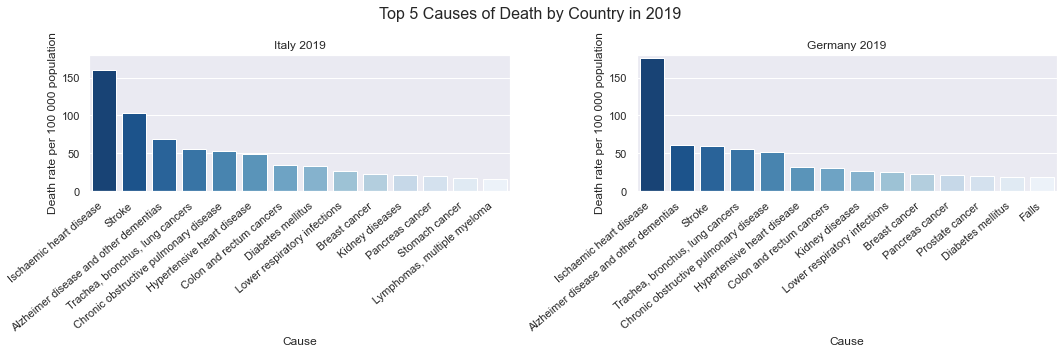

In [47]:
## Load data ##

# Chosen quantile
Q= 0.9

## ITALY
df_IT2019 = pd.read_excel("data/italy (1).xlsx")

df_IT2019=df_IT2019.sort_values(by=['Death rate per 100 000 population'],ascending=False)
z=df_IT2019['Death rate per 100 000 population'].quantile(q=Q,interpolation='linear')
df_IT2019_1=df_IT2019.loc[df_IT2019['Death rate per 100 000 population'] >= z]

## GERMANY
df_GE2019 = pd.read_excel("data/germany (1).xlsx")
df_GE2019=df_GE2019.sort_values(by=['Death rate per 100 000 population'],ascending=False)

y=df_GE2019['Death rate per 100 000 population'].quantile(q=Q,interpolation='linear')
df_GE2019_1=df_GE2019.loc[df_GE2019['Death rate per 100 000 population'] >= y]

## JAPAN
df_JA2019 = pd.read_excel("data/japan (1).xlsx")
df_JA2019= df_JA2019.sort_values(by=['Death rate per 100 000 population'],ascending=False)
df_JA2019
x=df_JA2019['Death rate per 100 000 population'].quantile(q=Q,interpolation='linear')

# Extract the top 50% of the data df_JA2019['Death rate per 100 000 population']
df_JA2019_1=df_JA2019.loc[df_JA2019['Death rate per 100 000 population'] >= x]

df_US2019 = pd.read_excel("data/united_states.xlsx")
df_US2019= df_US2019.sort_values(by=['Death rate per 100 000 population'],ascending=False)
df_US2019
w=df_US2019['Death rate per 100 000 population'].quantile(q=Q,interpolation='linear')

# Extract the top 50% of the data df_JA2019['Death rate per 100 000 population']
df_US2019_1=df_US2019.loc[df_US2019['Death rate per 100 000 population'] >= w]

print("IT:", df_IT2019_1.shape)
print("GE:", df_GE2019_1.shape)
print("JA:", df_JA2019_1.shape)
print("US:", df_US2019_1.shape)

## Plot the data ##
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=    False)

# Set the title
fig.suptitle('Top 5 Causes of Death by Country in 2019', fontsize=16)

sns.barplot(ax=ax[0], y="Death rate per 100 000 population", x="Cause", data=df_IT2019_1, palette="Blues_r")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right", fontsize=11)
ax[0].set_title('Italy 2019')
ax[0].set_ylabel('Death rate per 100 000 population')
ax[0].set_xlabel('Cause')
ax[0].set_ylim(0, 180)
sns.barplot(ax=ax[1], y="Death rate per 100 000 population", x="Cause", data=df_GE2019_1, palette="Blues_r")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right", fontsize=11)

ax[1].set_title('Germany 2019')
ax[1].set_ylabel('Death rate per 100 000 population')
ax[1].set_xlabel('Cause')
ax[1].set_ylim(0, 180)

plt.show()


We also wanted to investigate what are common reasons for people dying in different countries. To make the comparison fair, we attempted to choose 'peer' nations, in our case, Japan, US, Germany and Italy. The most effective way of conveying this comparison visually, we believe, is using a bar chart.

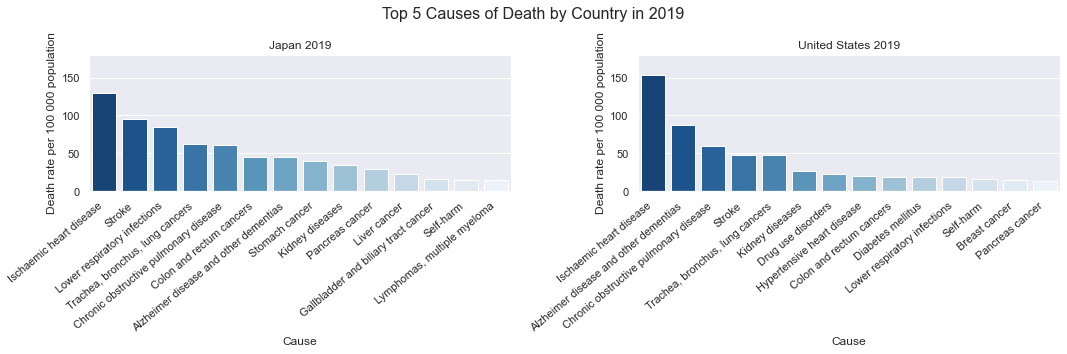

In [48]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharey=    False)
fig.suptitle('Top 5 Causes of Death by Country in 2019', fontsize=16)

sns.barplot(ax=ax[0], y="Death rate per 100 000 population", x="Cause", data=df_JA2019_1, palette="Blues_r")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right", fontsize=11)
ax[0].set_title('Japan 2019')
ax[0].set_ylabel('Death rate per 100 000 population')
ax[0].set_xlabel('Cause')
ax[0].set_ylim(0, 180)
sns.barplot(ax=ax[1], y="Death rate per 100 000 population", x="Cause", data=df_US2019_1, palette="Blues_r")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right", fontsize=11)

ax[1].set_title('United States 2019')
ax[1].set_ylabel('Death rate per 100 000 population')
ax[1].set_xlabel('Cause')
ax[1].set_ylim(0, 180)

plt.show()

### Meat Consumption by country

In [49]:
fig = go.Figure()

## Poultry ##
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[22,58,18,20],
    name='Poultry',
    orientation='h',
    marker=dict(
        color='peru',
        line=dict(color='peru', width=3)
    ), legendrank=6
))
## Beef ##
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[9.7,37,15,16],
    name='Beef',
    orientation='h',
    marker=dict(
        color='firebrick',
        line=dict(color='firebrick', width=3)
    ), legendrank=5
))
## Other Meats ##
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[0.1,0.8,0.83,1.09],
    name='Other Meats',
    orientation='h',
    marker=dict(
        color='darkgray',
        line=dict(color='darkgray', width=3)
    ), legendrank=4
))
## Pork ##
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[22,30,44,33],
    name='Pork',
    orientation='h',
    marker=dict(
        color='lightpink',
        line=dict(color='lightpink', width=3)
    ), legendrank=3
))
## Sheep/goat ##
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[0.15,0.6,0.97,0.77],
    name='Sheep/goat',
    orientation='h',
    marker=dict(
        color='purple',
        line=dict(color='purple', width=3)
    ), legendrank=2
))
## Seafood ##
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[47,22,13,30],
    name='Seafood',
    orientation='h',
    marker=dict(
        color='steelblue',
        line=dict(color='steelblue', width=3)
    ), legendrank=1
))
## Annotations ##

fig.add_trace(go.Scatter(
    x=[10],
    y=['Italy'],
    mode="text",
    name="Poultry",
    text=["20"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[10],
    y=['Germany'],
    mode="text",
    name="Poultry",
    text=["19"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[10],
    y=['USA'],
    mode="text",
    name="Poultry",
    text=["58"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[10],
    y=['Japan'],
    mode="text",
    name="Poultry",
    text=["23"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[77],
    y=['USA'],
    mode="text",
    name="Beef",
    text=["37"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[26],
    y=['Italy'],
    mode="text",
    name="Beef",
    text=["16"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[26],
    y=['Germany'],
    mode="text",
    name="Beef",
    text=["15"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[26],
    y=['Japan'],
    mode="text",
    name="Beef",
    text=["10"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[110],
    y=['USA'],
    mode="text",
    name="Pork",
    text=["30"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[45],
    y=['Italy'],
    mode="text",
    name="Pork",
    text=["33"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[45],
    y=['Germany'],
    mode="text",
    name="Pork",
    text=["44"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[45],
    y=['Japan'],
    mode="text",
    name="Pork",
    text=["22"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[85],
    y=['Italy'],
    mode="text",
    name="Seafood",
    text=["30"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[85],
    y=['Germany'],
    mode="text",
    name="Seafood",
    text=["13"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[85],
    y=['Japan'],
    mode="text",
    name="Seafood",
    text=["47"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[138],
    y=['USA'],
    mode="text",
    name="Seafood",
    text=["22"],
    textposition="middle center",
    showlegend=False
))
fig.update_traces(textfont_color='white')

# Add title
fig.update_layout(
    title_text="Per Capita Meat Consumption by Type - 2020",
    title_x=0.5,
    title_font=dict(
        size=20,
        color="black"
    )
)
# Set x-axis title
fig.update_xaxes(title_text="kg per year", title_font=dict(size=13, color="black"))

# Set x limit of 149
fig.update_layout(xaxis_range=[0, 149])
fig.update_layout(barmode='stack')

## Disable legend clicks
fig.update_layout(legend_itemclick=False)
fig.update_layout(legend_itemdoubleclick=False)

fig.write_html("plotly_time_consume_meattttttf.html")
fig.show()

Upon doing some research, it was clear that Japan stands out from other developed (especially Western) countries in terms of diet. We wanted to visualize this in an impactful way. We found data for meat consumption and were interested in both conveying something about the general meat consumption levels per capita, but also which kind of meat that is consumed. Accordingly, we made the above interactive horizontal bar chart, including stacked bars. Hence, the reader can both, at a glance, see how the overall meat consumption levels per capita compare, but also how much of each meat is consumed per country. Further, we annotated each category to make the comparison even more clear.

### Physical Activity, Suicide Rate, Obesity Rate and Daily Caloric Intake Bar Charts

To further compare Japan against its peer nations, US, Germany and Italy, we found above indicators that we wanted to compare. The most straightforward comparison, we thought, would be using static bar charts. These are simple to understand for our reader, which is why we included all four in the final narrative. The code and the plots can be seen below.

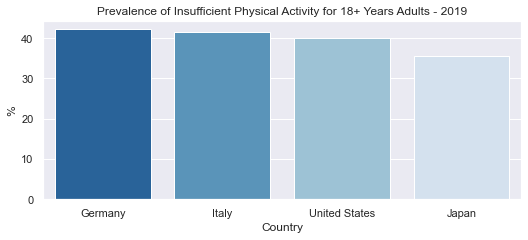

In [50]:
# Load data
physical_activity = pd.read_csv('data/physical_ac.csv')

# Only include data for countries USA, Japan, Germany, Italy
physical_activity = physical_activity[physical_activity['Unnamed: 0'].isin(['United States of America', 'Japan', 'Germany', 'Italy'])]

# Only include columns Unnamed: 0 and Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%)
physical_activity = physical_activity[['Unnamed: 0', 'Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%)']]

# Rename columns to Country Name
physical_activity.rename(columns={'Unnamed: 0': 'Country Name', 'Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%)': 'Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)'}, inplace=True)

# In column Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%) remove the 12 last characters
physical_activity['Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)'] = physical_activity['Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)'].str[:-12]

# In column Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%) convert to float
physical_activity['Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)'] = physical_activity['Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)'].astype(float)

# Sort by Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%)
physical_activity.sort_values(by='Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)', ascending = False, inplace=True)

# Reset index
physical_activity.reset_index(drop=True, inplace=True)

# Rename united states of america to United States
physical_activity['Country Name'] = physical_activity['Country Name'].str.replace('United States of America', 'United States')

# Make bar plot with countries on x axis and Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%) on y axis in sns theme
sns.barplot(data=physical_activity, x='Country Name', y='Prevalence of Insufficient Physical Activity for 18+ Years Adults (age-standardized estimate)', palette="Blues_r")
plt.title('Prevalence of Insufficient Physical Activity for 18+ Years Adults - 2019')
plt.ylabel('%') 
plt.xlabel('Country')
plt.show()

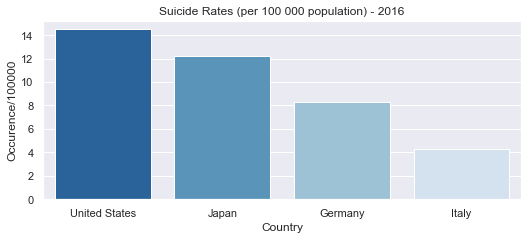

In [51]:
# Load data
sui = pd.read_csv('data/sui.csv')

# Only keep the first three columns 
sui = sui.iloc[:, :3]

# Drop first row
sui.drop(0, inplace=True)

sui['Age-standardized suicide rates (per 100 000 population)'] = sui['Age-standardized suicide rates (per 100 000 population)'].str[:4]
sui['Age-standardized suicide rates (per 100 000 population)'] = sui['Age-standardized suicide rates (per 100 000 population)'].astype(float)
sui = sui[sui['Unnamed: 1'] == 'Both sexes']
sui = sui[['Unnamed: 0', 'Age-standardized suicide rates (per 100 000 population)']]

# Only include countries 
sui = sui[sui['Unnamed: 0'].isin(['United States of America', 'Japan', 'Germany', 'Italy'])]

# Sort by Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%)
sui.sort_values(by='Age-standardized suicide rates (per 100 000 population)', ascending = False, inplace=True)

# Reset index
sui.reset_index(drop=True, inplace=True)

# Rename united states of america to United States
sui['Unnamed: 0'] = sui['Unnamed: 0'].str.replace('United States of America', 'United States')

# Make bar plot with countries on x axis and Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%) on y axis in sns theme
sns.barplot(data=sui, x='Unnamed: 0', y='Age-standardized suicide rates (per 100 000 population)', palette="Blues_r")
plt.title('Suicide Rates (per 100 000 population) - 2016')
plt.ylabel('Occurence/100000') 
plt.xlabel('Country')
plt.show()

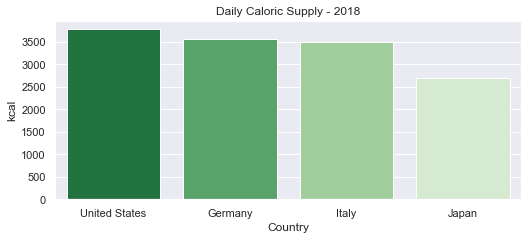

In [52]:
# Load data
kalo = pd.read_csv('data/daily-per-capita-caloric-supply.csv')

# Specify year
kalo = kalo[kalo['Year']==2018]

# Get specific countries
kalo = kalo[kalo['Entity'].isin(['United States', 'Japan', 'Germany', 'Italy'])]

# sort by Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%)
kalo.sort_values(by='Daily caloric supply (OWID based on UN FAO & historical sources)', ascending = False, inplace=True)

# reset index
kalo.reset_index(drop=True, inplace=True)

# Make bar plot with countries on x axis and Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%) on y axis in sns theme
sns.barplot(data=kalo, x='Entity', y='Daily caloric supply (OWID based on UN FAO & historical sources)', palette="Greens_r")
plt.title('Daily Caloric Supply - 2018')
plt.ylabel('kcal') 
plt.xlabel('Country')
plt.show()

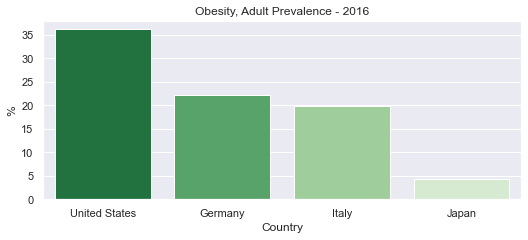

In [53]:
# Load data
obese = pd.read_csv('data/obesity.csv')

# Make bar plot with countries on x axis and Prevalence of insufficient physical activity among adults aged 18+ years (age-standardized estimate) (%) on y axis in sns theme
sns.barplot(data=obese, x='name', y='value', palette="Greens_r")
plt.title('Obesity, Adult Prevalence - 2016')
plt.ylabel('%') 
plt.xlabel('Country')
plt.show()

### How People Spend their Time

In [54]:
# Set MatPlotLib parameters
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

countries = ["Japan", "USA", "Germany", "Italy"]

## Define data from OECD and compute as percent of day (1440 = 24 hrs) ##
paid_work = [(325.711372/1440)*100, (251.137774/1440)*100, (223.83901/1440)*100, (148.894552/1440)*100]
education = [(36.980000/1440)*100, (31.418910/1440)*100, (24.042137/1440)*100, (27.814506/1440)*100]
care_for_house_hold_members = [(0.000000/1440)*100, (30.618280/1440)*100, (18.901665/1440)*100, (26.621509/1440)*100]
housework = [(80.370473/1440)*100, (99.900520/1440)*100, (109.354200/1440)*100, (134.714273/1440)*100]
shopping = [(24.928908/1440)*100,(22.013280/1440)*100, (32.090467/1440)*100, (27.742728/1440)*100]
other_paid_volunteer = [(97.724183/1440)*100, (65.190475/1440)*100, (52.598188/1440)*100, (43.145597/1440)*100]
sleep = [(442.020938/1440)*100, (528.019500/1440)*100, (498.381500/1440)*100, (513.320886/1440)*100]
eating_drinking = [(93.454218/1440)*100, (62.747670/1440)*100, (94.963150/1440)*100, (126.974855/1440)*100]
personal_care = [(84.562961/1440)*100, (57.438510/1440)*100, (54.677883/1440)*100, (67.512477/1440)*100]
sports = [(10.222600/1440)*100, (17.946540/1440)*100, (26.435250/1440)*100, (38.214086/1440)*100]
attending_events = [(8.225513/1440)*100, (0/1440)*100, (13.528252/1440)*100, (5.823313/1440)*100]
seeing_friends = [(16.912066/1440)*100, (43.543680/1440)*100, (60.646950/1440)*100, (65.357207/1440)*100]
tv_radio = [(103.224657/1440)*100, (148.308400/1440)*100, (118.465100/1440)*100, (103.692722/1440)*100]
other_leisure = [(147.953249/1440)*100, (73.490920/1440)*100+1, (112.076283/1440)*100, (110.171290/1440)*100]

## Plot with Plotly ##
fig = go.Figure()

## Add traces ##

## Paid Work
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=[(325.711372/1440)*100, (251.137774/1440)*100, (223.83901/1440)*100, (148.894552/1440)*100],
    name='Paid Work',
    orientation='h',
    marker=dict(
        color='red',
        line=dict(color='red', width=3)
    ), legendrank=14
))
## Education
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=education,
    name='Education',
    orientation='h',
    marker=dict(
        color='orange',
        line=dict(color='orange', width=3)
    ), legendrank=13
))
## Sleep
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=sleep,
    name='Sleep',
    orientation='h',
    marker=dict(
        color='grey',
        line=dict(color='grey', width=3)
    ), legendrank=12
))
## Unpaid/volunteer Work
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=other_paid_volunteer,
    name='Unpaid/volunteer Work',
    orientation='h',
    marker=dict(
        color='darkgoldenrod',
        line=dict(color='darkgoldenrod', width=3)
    ), legendrank=11
))
## Care for House Hold Members
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=care_for_house_hold_members,
    name='Care for House Hold Members',
    orientation='h',
    marker=dict(
        color='gold',
        line=dict(color='gold', width=3)
    ), legendrank=10
))
## Housework
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=housework,
    name='Housework',
    orientation='h',
    marker=dict(
        color='slateblue',
        line=dict(color='slateblue', width=3)
    ), legendrank=9
))
## Shopping
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=shopping,
    name='Shopping',
    orientation='h',
    marker=dict(
        color='darkslateblue',
        line=dict(color='darkslateblue', width=3)
    ), legendrank=8
))
## Personal Care
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=personal_care,
    name='Personal Care',
    orientation='h',
    marker=dict(
        color='yellow',
        line=dict(color='yellow', width=3)
    ), legendrank=7
))
## Eating/Drinking
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=eating_drinking,
    name='Eating/Drinking',
    orientation='h',
    marker=dict(
        color='green',
        line=dict(color='green', width=3)
    ), legendrank=6
))
## TV/Radio
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=tv_radio,
    name='TV/radio',
    orientation='h',
    marker=dict(
        color='navy',
        line=dict(color='navy', width=3)
    ), legendrank=5
))
## Seeing Friends
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=seeing_friends,
    name='Seeing Friends',
    orientation='h',
    marker=dict(
        color='darkgray',
        line=dict(color='darkgray', width=3)
    ), legendrank=4
))
## Sports
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=sports,
    name='Sports',
    orientation='h',
    marker=dict(
        color='black',
        line=dict(color='black', width=3)
    ), legendrank=3
))
## Attending Events
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=attending_events,
    name='Attending Events',
    orientation='h',
    marker=dict(
        color='skyblue',
        line=dict(color='skyblue', width=3)
    ), legendrank=2
))
## Other Leisure
fig.add_trace(go.Bar(
    y=["Japan", "USA", "Germany", "Italy"],
    x=other_leisure,
    name='Other Leisure',
    orientation='h',
    marker=dict(
        color='purple',
        line=dict(color='purple', width=3)
    ), legendrank=1
))
fig.add_trace(go.Scatter(
    x=[35],
    y=['Japan'],
    mode="text",
    name="Sleep",
    text=["7hr 22min"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[35],
    y=['USA'],
    mode="text",
    name="Sleep",
    text=["8hr 48min"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[35],
    y=['Germany'],
    mode="text",
    name="Sleep",
    text=["8hr 18min"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[35],
    y=['Italy'],
    mode="text",
    name="Sleep",
    text=["8hr 33min"],
    textposition="middle center",
    showlegend=False
))
fig.update_traces(textfont_color='white')

fig.add_trace(go.Scatter(
    x=[7.7],
    y=['Japan'],
    mode="text",
    name="Paid Work",
    text=["326min"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[7.7],
    y=['USA'],
    mode="text",
    name="Paid Work",
    text=["251min"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[7.7],
    y=['Germany'],
    mode="text",
    name="Paid Work",
    text=["224min"],
    textposition="middle center",
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=[7.7],
    y=['Italy'],
    mode="text",
    name="Paid Work",
    text=["149min"],
    textposition="middle center",
    showlegend=False
))
fig.update_traces(textfont_color='white')

# Add title
fig.update_layout(
    title_text="How People (15-64) Spend Their Time",
    title_x=0.5,
    title_font=dict(
        size=20,
        color="black"
    )
)
# Set x-axis title
fig.update_xaxes(title_text="% of Day", title_font=dict(size=13, color="black"))

# set x limit of 100
fig.update_layout(xaxis_range=[0, 100])
fig.update_layout(barmode='stack')
fig.update_layout(legend_itemclick=False)
fig.update_layout(legend_itemdoubleclick=False)

fig.write_html("plotly_time_consume_nonf.html")
fig.show()

Elaborating upon the topic of which influence lifestyle has on longevity, we wanted to make a visualization that provides the reader an overview of how people spend their time across the peer nations. That is what above bar chart does. This plot is important for our narrative, since it shows that Japan may not neccesarily lead the pack in all categories, especially, in terms of duration of paid work and sleep. That further affirmed our belief that it is the diet that matters. We decided to annotate the two most time-consuming tasks, Paid work and Sleep, since we believe the plot would be too crowded had we decided to annotate every single category. The plot is made interactive so that the reader can hover over the smallest of categories and even still get the exact value presented.

### Oldest Person Plot

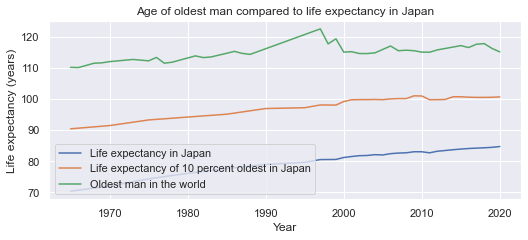

In [59]:
sns.set_theme()

# Load oldest person data
oldest = pd.read_csv('GDP_data/life_cap.csv')
#print(oldest)

# Load life tables
japan_life_table = pd.read_csv('life_tables/Japan.csv')
#for col in japan_life_table.columns:
#   print(col)
japan_life_table = japan_life_table[japan_life_table['TypeLT'] == 1]
japan_life_table = japan_life_table[["Age", "l(x)", "Sex", "Year1", "e(x)Orig", "e(x)"]]

# Find all values of year in data
years = japan_life_table['Year1'].unique()
all_lx = []
all_ex = []

for year in years:
    # Make plot for Japan 1960
    df = japan_life_table[japan_life_table['Year1'] == year]

    df = df.groupby(['Age']).sum()
    all_lx.append(df[['l(x)']].to_numpy().flatten() / 2)
    all_ex.append(df[['e(x)']].to_numpy().flatten() / 2)

all_lx = [x / x[0] for x in all_lx]

for i in [1, 0.1]:
    years_of_oldest_quantile = [np.argmax(x <= i) for x in all_lx]
    LE_at_years_of_oldest_quantile = [all_ex[i][years_of_oldest_quantile[i]] for i in range(len(years_of_oldest_quantile))]
    LE_at_quantile = np.array(years_of_oldest_quantile) + np.array(LE_at_years_of_oldest_quantile)
    only_years_after_1960 = [x for x in years if x >= 1964]
    only_LE_after_1960 = [x for i, x in enumerate(LE_at_quantile) if years[i] >= 1964]
    if i == 0.1:
        plt.plot(only_years_after_1960, only_LE_after_1960, label="Life expectancy of 10 percent oldest in Japan")
    else:
        plt.plot(only_years_after_1960, only_LE_after_1960, label="Life expectancy in Japan")
    
plt.plot(oldest['year'][1:], oldest['age'][1:], label="Oldest man in the world")
plt.legend()
plt.title("Age of oldest man compared to life expectancy in Japan")
plt.xlabel("Year")
plt.ylabel("Life expectancy (years)")
plt.show()

Finally, to show that life expectancy might not be able to increase infinitely, we found data on the oldest person alive through the last decades. We plotted that data together with the life expectancy of the 10% oldest in Japan and the overall life expectancy in Japan. We made a line plot, as we thought this would nicely illustrate the development through time and how it seems to have slowly stagnated for all three. This plot is essential for our narrative since we use it to summarize and reflect on the fact that even if you lived perfectly healthily, your chances of living much beyond those 100 years are not completely certain, as there are other factors than lifestyle habits involved.

#### Gini Index Vs. Life Expectancy (not included in final story)

Empty DataFrame
Columns: [2019]
Index: [] Empty DataFrame
Columns: [2019_life_expectancy]
Index: []


Text(0, 0, 'Italy')

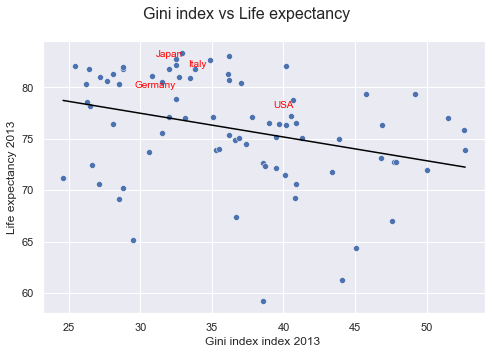

In [60]:
# Life expectancy data
df = pd.read_csv("life_expectancy_by_country.csv")
df.head(5)

# Copy df to df1
df1 = df.copy()
df1=df1.fillna(0)

# Extract dates 2019-1960-
df_2019 = df1[df1['year'] == 2019]
df_2019= df_2019.rename(columns={'country_name':'Country Name'})
df_2019= df_2019.rename(columns={'value':'life_expectancy'})

# Extract dates 2019-2000-
df_2019 = df1[df1['year'] == 2019]
df_2019 = df_2019[['country_name','value']]
df_2019 = df_2019.rename(columns={'country_name':'Country Name'})
df_2019 = df_2019.rename(columns={'value':'2019_life_expectancy'})

df_2000 = df1[df1['year'] == 2000]
df_2000 = df_2000[['country_name','value']]
df_2000 = df_2000.rename(columns={'country_name':'Country Name'})
df_2000 = df_2000.rename(columns={'value':'2000_life_expectancy'})

df_1960 = df1[df1['year'] == 1960]
df_1960 = df_1960[['country_name','value']]
df_1960 = df_1960.rename(columns={'country_name':'Country Name'})
df_1960 = df_1960.rename(columns={'value':'1960_life_expectancy'})

df_2013 = df1[df1['year'] == 2013]
df_2013 = df_2013[['country_name','value']]
df_2013= df_2013.rename(columns={'country_name':'Country Name'})
df_2013= df_2013.rename(columns={'value':'2013_life_expectancy'})

# Gini index data
path_Gini="GDP_data/API_SI.POV.GINI_DS2_en_csv_v2_5358360.csv"
df_Gini=pd.read_csv(path_Gini, skiprows=4)

# Remove  last column of df_Gini
df_Gini=df_Gini.drop(df_Gini.columns[[-1]], axis=1)

df_Gini=df_Gini.fillna(0)
df_Gini.head(2)

# Extract japan data
df_Gini_japan=df_Gini[df_Gini['Country Name']=='Japan']

df_Gini_= df_Gini[["Country Name","2019", "2000", "1960"]]
df_Gini_m = pd.merge(df_Gini_, df_1960, on='Country Name', how='outer')
df_Gini_m = pd.merge(df_Gini_m, df_2000, on='Country Name', how='outer')
df_Gini_m = pd.merge(df_Gini_m, df_2019, on='Country Name', how='outer')

df_Gini_2013= df_Gini[["Country Name","2013"]]
df_Gini_2013=pd.merge(df_Gini_2013, df_2013, on='Country Name', how='outer')
df_Gini_2013=df_Gini_2013[df_Gini_2013['2013'] != 0]

df_Gini_m=df_Gini_m.fillna(0)

# Remove lines with 0 or Nan values
df_Gini_m_2019=df_Gini_m[df_Gini_m['2019'] != 0]
df_Gini_m_2000=df_Gini_m[df_Gini_m['2000'] != 0]
df_Gini_m_1960=df_Gini_m[df_Gini_m['1960'] != 0]

## HERE IS SHOWN THA GINI DATA FOR JAPAN ARE NOT AVAILABLE FOR MOST OF THE YEARS
df_Gini_m_2019.loc[df_Gini_m_2019['Country Name'] == 'Japan']

y, x = (df_Gini_m_2019.loc[df_Gini_m_2019['Country Name']=="Japan"][["2019"]],  df_Gini_m_2019.loc[df_Gini_m_2019['Country Name']=="Japan"][["2019_life_expectancy"]])
print(y, x)

# Plot Gini index vs life expectancy 2013
fig, ax = plt.subplots( figsize=(7, 5))
fig.suptitle('Gini index vs Life expectancy', fontsize=16)

sns.scatterplot(x='2013', y=str('2013_life_expectancy'), data=df_Gini_2013, ax=ax)

ax.set_xlabel('Gini index index 2013 ')
ax.set_ylabel('Life expectancy 2013')
xfid = np.linspace(df_Gini_2013['2013'].min() ,df_Gini_2013['2013'].max(), 100)
sl, inte, r_value, p_value, std_err = linregress((df_Gini_2013['2013']), ( df_Gini_2013['2013_life_expectancy']))

ax.plot(xfid, sl*xfid+inte, color="black")

# Annotation of Japan
(x, y) = (df_Gini_2013.loc[df_Gini_2013['Country Name']=="Japan"]["2013"].astype(int).to_numpy()[0],  df_Gini_2013.loc[df_Gini_2013['Country Name']=="Japan"]["2013_life_expectancy"].astype(int).to_numpy()[0])
ax.annotate("Japan", (x, y), fontsize=10, color="red", xytext=(0, 0),
                 textcoords='offset points', ha="center")

# Annotation of USA
(x, y) = (df_Gini_2013.loc[df_Gini_2013['Country Name']=="United States"]["2013"].astype(int).to_numpy()[0],  df_Gini_2013.loc[df_Gini_2013['Country Name']=="United States"]["2013_life_expectancy"].astype(int).to_numpy()[0])
ax.annotate("USA", (x, y), fontsize=10, color="red", xytext=(0, 0),
                    textcoords='offset points', ha="center")

# Annotation of Germnay
(x, y) = (df_Gini_2013.loc[df_Gini_2013['Country Name']=="Germany"]["2013"].astype(int).to_numpy()[0],  df_Gini_2013.loc[df_Gini_2013['Country Name']=="Germany"]["2013_life_expectancy"].astype(int).to_numpy()[0])
ax.annotate("Germany", (x, y), fontsize=10, color="red", xytext=(0, 0),
                 textcoords='offset points', ha="center")

# Annotation of Italy
(x, y) = (df_Gini_2013.loc[df_Gini_2013['Country Name']=="Italy"]["2013"].astype(int).to_numpy()[0],  df_Gini_2013.loc[df_Gini_2013['Country Name']=="Italy"]["2013_life_expectancy"].astype(int).to_numpy()[0])
ax.annotate("Italy", (x, y), fontsize=10, color="red", xytext=(0, 0),
                    textcoords='offset points', ha="center")   

During the data analysis stage, we also explored the relationship between the Gini index, a measure used for inequality, and the life expectancy. We opted to exclude this analysis since our assessment is that we already have enough content in the global overview part of our story.

## Discussion

Think critically about your creation

What went well?

What is still missing? What could be improved?, Why?

## Contributions

Who did what?

You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).

It is not OK simply to write "All group members contributed equally".

Make sure that you use references when they're needed and follow academic standards.
Handing in the assignment: Simply upload the link to your website to peergrade.